<a href="https://colab.research.google.com/github/TimilsinaSushil/Thesis/blob/DNN/DNN_after_applying_k_fold_in_both_coarse_and_fine_type.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==1.3.1+cpu -f https://download.pytorch.org/whl/torch_stable.html
!pip install inltk
!pip install nepali-stemmer

In [6]:
from inltk.inltk import setup
from inltk.inltk import tokenize
from inltk.inltk import get_embedding_vectors
from nepali_stemmer.stemmer import NepStemmer
# setup('ne')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('QSN.csv')

Saving QSN.csv to QSN.csv


['temporal' 'location' 'numerical' 'person' 'organization' 'explanation' 'miscellaneous']


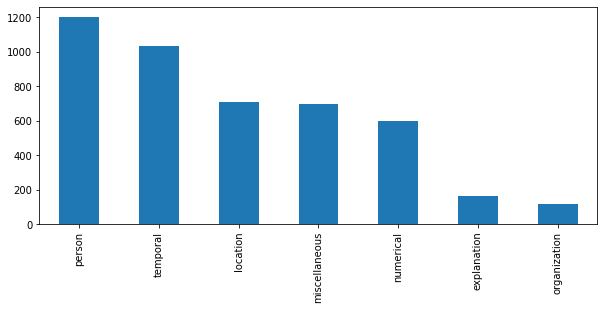

In [8]:
#coarse type filtering
df=df[df['CoarseType'].isin(['location','temporal','numerical','person','organization','explanation','miscellaneous'])]
coarse_type=df['CoarseType'].unique()
print(coarse_type)
plt.figure(figsize=(10,4))
df.CoarseType.value_counts().plot(kind='bar');


**Text Preprocessig**

In [9]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
#removing text inside brackets and quotes
import re
def removeTextInsideQuotesAndBrackets(text):
  text=re.sub("[\(\[].*?[\)\]]", "", text)
  text=re.sub("\'.*?\'","",text)
  text=re.sub('\".*?\"',"",text)
  return text

In [11]:
def removeKo(text):
  words= text.split()
  text=[]
  for word in words:
    length=len(word)
    if(length > 2):
      if(word[-2]=='क' and word[-1]=='ो'):
        if(word!='कसको'):
          word= word[:length-2]
    text.append(word)
  text=' '.join([word for word in text])
  # print(text)
  return text




In [12]:
def preprocessing(questions):
  questions=questions.apply(removeTextInsideQuotesAndBrackets)
  questions = questions.apply(removeKo)
  #tokenization
  questions= questions.apply(lambda x: tokenize(x,'ne'))
  #removing duplicates
  questions= questions.apply(lambda x: list(dict.fromkeys(x)))
  
  questions=questions.apply(lambda x: ' '.join(x).replace('▁','').split())
  questions=questions.apply(lambda x: ' '.join(x))

  #removing numbers
  questios=questions.apply(lambda x: ''.join(c for c in x if not c.isdigit()))
  #removing punctuation
  punctuation=['!','"','#','$','&',"'",'(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[',"]",'^','_','`','{','|','}','~']
  questions = questions.apply(lambda x: ''.join(c for c in x if c not in punctuation))

  #removing stopwords
  WHWORDS = ['कुन','कहिले','के','कति','को','कसले','कहाँ','कसलाई','कसको','कस्तो','कति','कसरी','किन','कता']
  STOPWORDS = stopwords.words('nepali')
  # Removig WH words from STOPWORDS
  for word in WHWORDS:
    if word in STOPWORDS: STOPWORDS.remove(word)

  STOPWORDS=set(STOPWORDS)
  def clean_text(text):
      text=' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
      return text
  questions = questions.apply(clean_text)
  return questions



In [ ]:
#stemmig
# nepstem = NepStemmer()
# df['Questions'] = df['Questions'].apply(nepstem.stem)
# df.head(10)

In [13]:
df['Questions'] = preprocessing(df['Questions'])

dataset=df

df.head()

,Questions,Answer,CoarseType,FineType,WhWord,Domain
0,नेपाली क्रिकेट टिम क्याप्टेन ज्ञानेन्द्र मल्ल ...,वि.सं. २०७६ कार्तिक १३,temporal,date,कहिले,Sports
1,फ्रान्स लियोन सम्पन्न महिला विश्वकप फुटबल २०१९...,अमेरिका,location,country,कसले,Sports
2,विश्व शान्ति सू चा ंक २०१९ नेपाल कति औ स्थानमा...,७६ औ स्थानमा,numerical,rank,कति,Miscellaneous
3,फलफूल बोट रु दश नोट कार्यक्रम सुरुवात कुन जिल्...,"इच्छाकामना गाउँपालिका, चितवन",location,city,कुन,Politics
4,माथिल्लो त्रिशुली थ्री जल विध ुत आयोजना विधुत ...,वि.स. २०७६ जेठ ०२,temporal,date,कहिले,Miscellaneous


*The topology of a neural network that classifies text is somewhat different than that of the networks presented thus far. It still has a dense layer (or layers), and it still has a sigmoid output layer with one neuron for binary classification or a softmax output layer with one neuron per class for multiclass classification. But preceding those layers are an embedding layer and a flatten layer. The former uses word embeddings to transform arrays, or sequences, of scalar values representing words into arrays of word vectors, which encode information about relationships between words. The latter “flattens” the 2D arrays output by the embedding layer into 1D arrays that can be input to a dense layer.*

In [14]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Questions'])
sequences = tokenizer.texts_to_sequences(df['Questions'])
# print(sequences)

*Neural network expects all sequences to be the same length. Keras’s pad_sequences function performs this final step, truncating sequences longer than the specified length and padding sequences shorter than the specified length with 0s:*

In [15]:
from keras.preprocessing.sequence import pad_sequences
padded_sequences = pad_sequences(sequences, maxlen=100)
print(padded_sequences)

[[   0    0    0    0 ... 1101  104    3  227]
 [   0    0    0    0 ...   56    7   63  201]
 [   0    0    0    0 ...    4  414  148   26]
 [   0    0    0    0 ...    1   72  237  958]
 ...
 [   0    0    0    0 ... 2085 3368   13  252]
 [   0    0    0    0 ...    4  355 3367  246]
 [   0    0    0    0 ...  528  144 1141   36]
 [   0    0    0    0 ...  528  144 1141   36]]


*The first hidden layer in a neural network that classifies text is an embedding layer whose job is to convert padded sequences of word indices into arrays of word vectors, which represent each word with an array of floating-point numbers rather than a single integer. Each word in the input text is represented by a vector in the embedding layer, and as the network is trained, vectors representing individual words are adjusted to reflect their relationship to one another. If you’re building a sentiment-analysis model and words such as “excellent” and “amazing” are generally associated with positive sentiment, then the vectors representing those words in the embedding space should be relatively close together so phrases such as “excellent service” and “amazing service” score similarly*

**One hot encoding of labels**

In [16]:
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
le = preprocessing.LabelEncoder()
y=df.CoarseType;
print(y.unique())
y = le.fit_transform(y)
y = to_categorical(y) 

['temporal' 'location' 'numerical' 'person' 'organization' 'explanation' 'miscellaneous']


**Coarse Grained Classification**

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 32)           320000    
                                                                 
 flatten_8 (Flatten)         (None, 3200)              0         
                                                                 
 dense_16 (Dense)            (None, 128)               409728    
                                                                 
 dense_17 (Dense)            (None, 7)                 903       
                                                                 
Total params: 730,631
Trainable params: 730,631
Non-trainable params: 0
_________________________________________________________________
TRAIN: [   0    1    2    3 ... 3607 3608 3609 3610] VALIDATION: [   4   12   13   15 ... 3603 3605 3611 3612]
Epoch 1/10
132/132 [==============================] - 3s 14ms/step - 

Text(48.49999999999999, 0.5, 'Actual label')

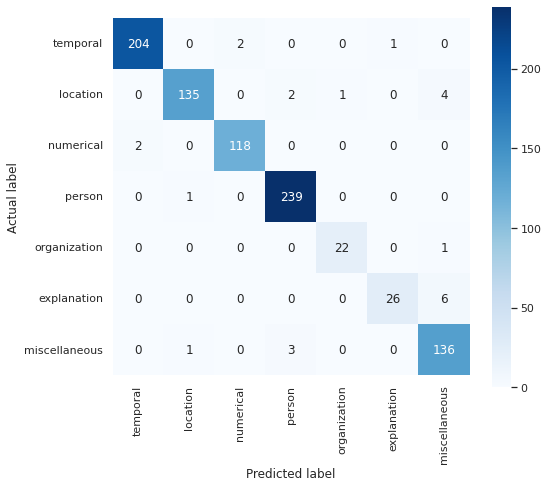

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report



x=padded_sequences;
x_train, x_test, y_train, y_test = train_test_split(x, y,stratify=y,test_size=0.20) 
metrics = []
skf= StratifiedKFold(n_splits=6, shuffle=True, random_state=1)
# x=np.array(x_train)
# y=np.array(y_train)


# from keras.optimizers import Adam
model = Sequential() 
model.add(Embedding(10000, 32, input_length=100)) 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy']) 
#default value of learning rate will be 0.001
#adam is a variant of SGD(Sochastic gradient descent). Learning rate should be between (0.0001 to 0.1).Objective: Minimize the loss between actual output and predicted output.
model.optimizer.lr=0.002
model.summary()

# K fold cross validation
for train_index, validation_index in skf.split(x_train, y_train.argmax(1)):
    print("TRAIN:", train_index, "VALIDATION:", validation_index)
    x_train, x_validation = x[train_index], x[validation_index]
    y_train, y_validation = y[train_index], y[validation_index]
#   # train the model
    # print(x_train)
    # print(y_train.argmax(1))
    hist = model.fit(x_train, y_train, epochs=10, batch_size=22)
#   # validate the model 
    y_pred_class_for_validation = model.predict(x_validation)
    metrics.append(accuracy_score(y_pred_class_for_validation.argmax(axis=1), y_validation.argmax(axis=1)))
    # print(classification_report(y_test, y_pred_class,target_names=coarse_type))


metrics = np.array(metrics)
print('Validation Accuracy for each Iteration',metrics)
print('Mean accuracy for validation set: ', np.mean(metrics, axis=0))
print('Std for accuracy: ', np.std(metrics, axis=0))
print('---------------------------------------------------------------------------------')

y_pred = model.predict(x_test)

test_accuracy = accuracy_score(y_pred.argmax(axis=1), y_test.argmax(axis=1))
print('Test Accuracy : %s' % test_accuracy)
# print(y_pred.argmax(axis=1))
# print(y_test.argmax(axis=1))
labels=y.argmax(axis=1)
labels=le.inverse_transform(labels)
labels=np.unique(labels)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1),target_names=labels))

mat = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1),labels=le.fit_transform(df.CoarseType.unique()))
import seaborn as sns
plt.figure(figsize=(8,7))
sns.set()
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=df.CoarseType.unique(), yticklabels=df.CoarseType.unique())
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')




**Plotting**

In [18]:
acc = hist.history['categorical_accuracy']
val = hist.history['val_categorical_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_predicted = model.predict(x_test)

print(y_test);
print(y_test.argmax(axis=1))

test_accuracy = accuracy_score(y_predicted.argmax(axis=1), y_test.argmax(axis=1))
print('Test Accuracy : %s' % test_accuracy)
print(classification_report(y_test.argmax(axis=1), y_predicted.argmax(axis=1),target_names=df.CoarseType.unique()))


# print(y_test);
# print(y_predicted);
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1),labels=le.fit_transform(df.CoarseType.unique()))
import seaborn as sns
plt.figure(figsize=(8,7))
sns.set()
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=df.CoarseType.unique(), yticklabels=df.CoarseType.unique())
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

KeyError: ignored

**Fine Grained Classification Model**

In [22]:
def dnnFineGrained(coarse_type,fine_types,epoch,learning_rate,test_size,k_fold):
  #decleration
  from keras.models import Sequential
  from keras.layers import Dense, Flatten
  from keras.layers.embeddings import Embedding
  from sklearn.model_selection import train_test_split
  output_shape=len(fine_types)
  # print(output_shape);
  subset=dataset[dataset['CoarseType']==coarse_type]
  subsetFineTypes=subset['FineType'].unique()
  # print(subsetFineTypes)
  subset= subset[subset['FineType'].isin(fine_types)]
  print(len(subset))



  from keras.preprocessing.text import Tokenizer
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(subset['Questions'])
  sequences = tokenizer.texts_to_sequences(subset['Questions'])


  from keras.preprocessing.sequence import pad_sequences
  padded_sequences = pad_sequences(sequences, maxlen=100)
  x=padded_sequences


  from sklearn import preprocessing
  from tensorflow.keras.utils import to_categorical
  le = preprocessing.LabelEncoder()
  y=subset.FineType
  y = le.fit_transform(y)
  y = to_categorical(y) 

  #train-test splitting
  x_train, x_test, y_train, y_test = train_test_split(x, y,stratify=y,test_size=test_size) 
  metrics = []
  skf= StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=1)

  #Model
  model = Sequential() 
  model.add(Embedding(10000, 32, input_length=100)) 
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(output_shape, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  model.optimizer.lr=learning_rate
  # print(model.optimizer.lr)
  # model.summary()
  
  # K fold cross validation
  for train_index, validation_index in skf.split(x_train, y_train.argmax(1)):
      print("TRAIN:", train_index, "VALIDATION:", validation_index)
      x_train, x_validation = x[train_index], x[validation_index]
      y_train, y_validation = y[train_index], y[validation_index]
  #   # train the model
      # print(x_train)
      # print(y_train.argmax(1))
      hist = model.fit(x_train, y_train, epochs=epoch, batch_size=22)
  #   # validate the model 
      y_pred_class_for_validation = model.predict(x_validation)
      metrics.append(accuracy_score(y_pred_class_for_validation.argmax(axis=1), y_validation.argmax(axis=1)))

  metrics = np.array(metrics)
  print('Validation Accuracy for each Iteration',metrics)
  print('Mean accuracy for validation set: ', np.mean(metrics, axis=0))
  print('Std for accuracy: ', np.std(metrics, axis=0))
  print('---------------------------------------------------------------------------------')

  y_pred = model.predict(x_test)

  test_accuracy = accuracy_score(y_pred.argmax(axis=1), y_test.argmax(axis=1))
  print('Test Accuracy : %s' % test_accuracy)
  # print(y_pred.argmax(axis=1))
  # print(y_test.argmax(axis=1))
  labels=y.argmax(axis=1)
  labels=le.inverse_transform(labels)
  labels=np.unique(labels)
  print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1),target_names=labels))

  mat = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1),labels=le.fit_transform(labels))
  import seaborn as sns
  plt.figure(figsize=(8,7))
  sns.set()
  sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=labels, yticklabels=labels)
  
  plt.xlabel('Predicted label')
  plt.ylabel('Actual label')


 
  # #plotting
  # acc = hist.history['categorical_accuracy']
  # val = hist.history['val_categorical_accuracy']
  # epochs = range(1, len(acc) + 1)
  # # plt.figure(figsize=(8,6))
  # plt.plot(epochs, acc, '-', label='Training accuracy')
  # plt.plot(epochs, val, ':', label='Validation accuracy')
  # plt.title('Training and Validation Accuracy')
  # plt.xlabel('Epoch')
  # plt.ylabel('Accuracy')
  # plt.legend(loc='lower right')
  # plt.plot()

  # from sklearn.metrics import confusion_matrix
  # from sklearn.metrics import accuracy_score
  # from sklearn.metrics import classification_report
  
  # y_predicted = model.predict(x_test)
  # # print(y_test);
  # # print(y_predicted);

  # labels=y.argmax(axis=1)
  # labels=le.inverse_transform(labels)
  # labels=np.unique(labels)
  
  # #classification report
  # test_accuracy = accuracy_score(y_predicted.argmax(axis=1), y_test.argmax(axis=1))
  # print('Test Accuracy : %s' % test_accuracy)
  # print(classification_report(y_test.argmax(axis=1), y_predicted.argmax(axis=1),target_names=labels))

  # #confusion Matrix
  # mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1), labels=le.fit_transform(labels))
  # import seaborn as sns
  # plt.figure(figsize=(8,7))
  # sns.set()
  # sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=labels, yticklabels=labels)

  # # ax=sns.heatmap(mat, square=True, annot=True, fmt='d', cmap='Blues')
  # plt.xlabel('Predicted Intent')
  # plt.ylabel('Actual Intent')
 

  
 


**Person**

1193
TRAIN: [  0   1   2   3 ... 948 949 950 952] VALIDATION: [  5   9  12  19 ... 945 946 951 953]
Epoch 1/20
35/35 [==============================] - 1s 14ms/step - loss: 0.4722 - categorical_accuracy: 0.8807
Epoch 2/20
35/35 [==============================] - 1s 14ms/step - loss: 0.2623 - categorical_accuracy: 0.9174
Epoch 3/20
35/35 [==============================] - 0s 13ms/step - loss: 0.1293 - categorical_accuracy: 0.9620
Epoch 4/20
35/35 [==============================] - 1s 14ms/step - loss: 0.0742 - categorical_accuracy: 0.9712
Epoch 5/20
35/35 [==============================] - 0s 10ms/step - loss: 0.0474 - categorical_accuracy: 0.9908
Epoch 6/20
35/35 [==============================] - 0s 10ms/step - loss: 0.0340 - categorical_accuracy: 0.9908
Epoch 7/20
35/35 [==============================] - 0s 11ms/step - loss: 0.0221 - categorical_accuracy: 0.9948
Epoch 8/20
35/35 [==============================] - 0s 10ms/step - loss: 0.0128 - categorical_accuracy: 0.9987
Epoch 9/20
3

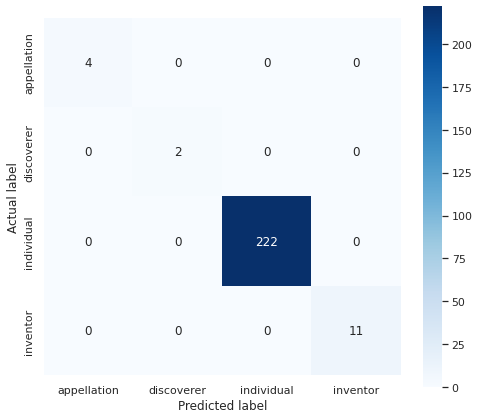

In [23]:
# ['individual' 'inventor' 'discoverer' 'appellation' 'group' 'other']
coarse_type='person';
fine_types=['individual','inventor','discoverer','appellation']
epoch=20
learning_rate=0.002
test_size=0.20
k_fold=5
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate,test_size,k_fold)

**Organization**

59
TRAIN: [ 0  1  2  3  4  5  6  7  9 11 12 13 14 15 16 19 21 22 24 25 26 27 28 29 32 33 34 35 36 37 38 39 40 41 43 45 46] VALIDATION: [ 8 10 17 18 20 23 30 31 42 44]
Epoch 1/50
2/2 [==============================] - 1s 16ms/step - loss: 1.0336 - categorical_accuracy: 0.4324
Epoch 2/50
2/2 [==============================] - 0s 16ms/step - loss: 0.9698 - categorical_accuracy: 0.5405
Epoch 3/50
2/2 [==============================] - 0s 14ms/step - loss: 0.9202 - categorical_accuracy: 0.6486
Epoch 4/50
2/2 [==============================] - 0s 15ms/step - loss: 0.8720 - categorical_accuracy: 0.8649
Epoch 5/50
2/2 [==============================] - 0s 17ms/step - loss: 0.8077 - categorical_accuracy: 0.7027
Epoch 6/50
2/2 [==============================] - 0s 16ms/step - loss: 0.7448 - categorical_accuracy: 0.5676
Epoch 7/50
2/2 [==============================] - 0s 14ms/step - loss: 0.6954 - categorical_accuracy: 0.5405
Epoch 8/50
2/2 [==============================] - 0s 20ms/step - loss:

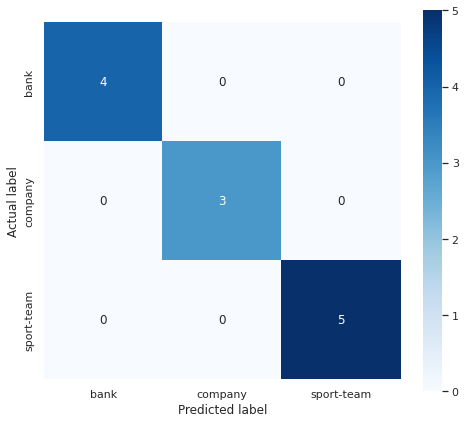

In [25]:
coarse_type='organization';
fine_types=['sport-team','bank','company']
epoch=50
learning_rate=0.002
test_size=0.20
k_fold=5
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate,test_size,k_fold)

**Location**

630
TRAIN: [  0   1   2   3 ... 499 500 501 502] VALIDATION: [  8  13  29  31 ... 495 496 497 503]
Epoch 1/30
19/19 [==============================] - 1s 14ms/step - loss: 1.6385 - categorical_accuracy: 0.4417
Epoch 2/30
19/19 [==============================] - 0s 17ms/step - loss: 1.2641 - categorical_accuracy: 0.5533
Epoch 3/30
19/19 [==============================] - 0s 19ms/step - loss: 0.7900 - categorical_accuracy: 0.7543
Epoch 4/30
19/19 [==============================] - 0s 16ms/step - loss: 0.4271 - categorical_accuracy: 0.9007
Epoch 5/30
19/19 [==============================] - 0s 11ms/step - loss: 0.1754 - categorical_accuracy: 0.9777
Epoch 6/30
19/19 [==============================] - 0s 10ms/step - loss: 0.0695 - categorical_accuracy: 0.9950
Epoch 7/30
19/19 [==============================] - 0s 12ms/step - loss: 0.0339 - categorical_accuracy: 0.9975
Epoch 8/30
19/19 [==============================] - 0s 10ms/step - loss: 0.0187 - categorical_accuracy: 1.0000
Epoch 9/30
19

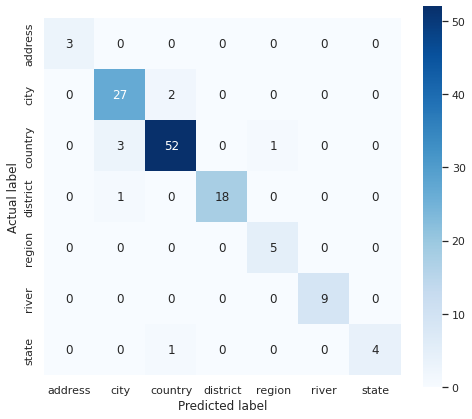

In [26]:
coarse_type='location';
fine_types=['country','city','district','river','region','state','address']
epoch=30
learning_rate=0.003
test_size=0.20
k_fold=5
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate,test_size,k_fold)

**Temporal**

525
TRAIN: [  0   1   2   3 ... 416 417 418 419] VALIDATION: [ 14  19  24  27 ... 409 411 414 415]
Epoch 1/30
16/16 [==============================] - 1s 14ms/step - loss: 1.3780 - categorical_accuracy: 0.5446
Epoch 2/30
16/16 [==============================] - 0s 14ms/step - loss: 1.0742 - categorical_accuracy: 0.6190
Epoch 3/30
16/16 [==============================] - 0s 14ms/step - loss: 0.6865 - categorical_accuracy: 0.7440
Epoch 4/30
16/16 [==============================] - 0s 22ms/step - loss: 0.3919 - categorical_accuracy: 0.9405
Epoch 5/30
16/16 [==============================] - 0s 21ms/step - loss: 0.2060 - categorical_accuracy: 0.9583
Epoch 6/30
16/16 [==============================] - 0s 18ms/step - loss: 0.0923 - categorical_accuracy: 0.9911
Epoch 7/30
16/16 [==============================] - 0s 15ms/step - loss: 0.0359 - categorical_accuracy: 0.9940
Epoch 8/30
16/16 [==============================] - 0s 14ms/step - loss: 0.0194 - categorical_accuracy: 0.9940
Epoch 9/30
16

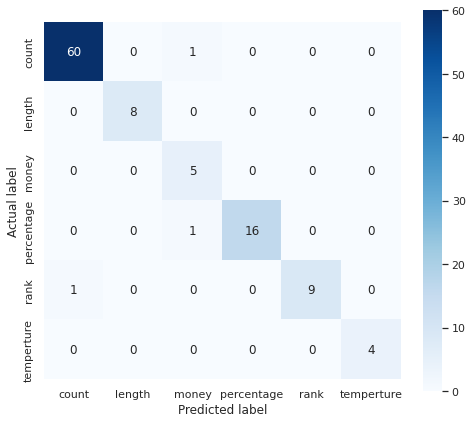

In [27]:
coarse_type='numerical';
fine_types= ['count','percentage','rank','length','money','temperture']
epoch=30
learning_rate=0.003
test_size=0.20
k_fold=5
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate,test_size,k_fold)

**Explanation**

161
TRAIN: [  0   1   2   3 ... 123 124 126 127] VALIDATION: [ 14  23  36  40  57  60  62  77  78  84  85  87  88  91  94  96 102 105 107 108 112 115 116 119 121 125]
Epoch 1/10
5/5 [==============================] - 1s 17ms/step - loss: 0.6768 - categorical_accuracy: 0.6863
Epoch 2/10
5/5 [==============================] - 0s 19ms/step - loss: 0.4715 - categorical_accuracy: 0.8725
Epoch 3/10
5/5 [==============================] - 0s 22ms/step - loss: 0.3988 - categorical_accuracy: 0.8725
Epoch 4/10
5/5 [==============================] - 0s 22ms/step - loss: 0.3567 - categorical_accuracy: 0.8725
Epoch 5/10
5/5 [==============================] - 0s 20ms/step - loss: 0.2673 - categorical_accuracy: 0.8824
Epoch 6/10
5/5 [==============================] - 0s 28ms/step - loss: 0.1770 - categorical_accuracy: 0.9314
Epoch 7/10
5/5 [==============================] - 0s 21ms/step - loss: 0.1117 - categorical_accuracy: 0.9608
Epoch 8/10
5/5 [==============================] - 0s 20ms/step - loss:

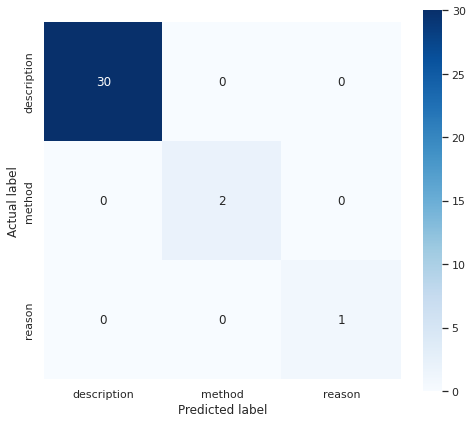

In [28]:
coarse_type='explanation';
fine_types= ['description','method','reason']
epoch=10
learning_rate=0.003
test_size=0.20
k_fold=5
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate,test_size,k_fold)

**Miscellaneous**

222
TRAIN: [  0   1   2   3 ... 172 173 174 175] VALIDATION: [  4   5  15  19  23  27  33  46  51  62  64  66  67  80  81  82  83  86  98 106 108 111 115 116 118 120 130 132 134
 140 150 153 157 167 169 176]
Epoch 1/30
7/7 [==============================] - 1s 16ms/step - loss: 2.0204 - categorical_accuracy: 0.3688
Epoch 2/30
7/7 [==============================] - 0s 16ms/step - loss: 1.6532 - categorical_accuracy: 0.4965
Epoch 3/30
7/7 [==============================] - 0s 16ms/step - loss: 1.1723 - categorical_accuracy: 0.6312
Epoch 4/30
7/7 [==============================] - 0s 16ms/step - loss: 0.6903 - categorical_accuracy: 0.7730
Epoch 5/30
7/7 [==============================] - 0s 23ms/step - loss: 0.3387 - categorical_accuracy: 0.9362
Epoch 6/30
7/7 [==============================] - 0s 16ms/step - loss: 0.1325 - categorical_accuracy: 0.9858
Epoch 7/30
7/7 [==============================] - 0s 20ms/step - loss: 0.0376 - categorical_accuracy: 1.0000
Epoch 8/30
7/7 [=============

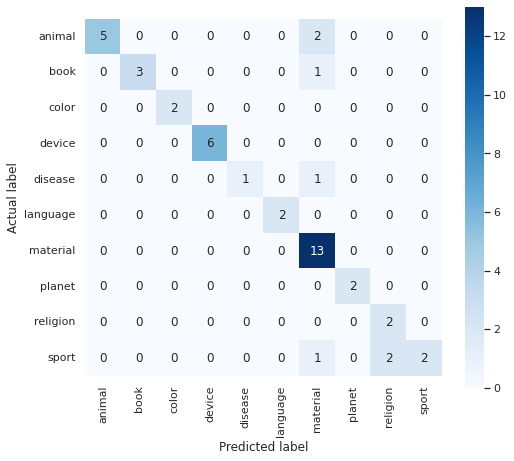

In [29]:
coarse_type='miscellaneous';
fine_types= ['material','animal','device','sport','book','planet','color','religion','disease','language']
epoch=30
learning_rate=0.007
test_size=0.20
k_fold=5
dnnFineGrained(coarse_type,fine_types,epoch,learning_rate,test_size,k_fold)